# Image Audio Video Search with Meta AI ImageBind
This recipe demonstrates how build multi-modal search (image, audio, video) `Meta AI ImageBind` model ([multi2vec-bind](https://weaviate.io/developers/weaviate/modules/retriever-vectorizer-modules/multi2vec-bind)).

ImageBind allows us to search through text, image, audio and video.

This recipe will focus on searching through image, audio, video (skipping searching through text):
* [text-to-media search](#text-to-media-search) - provide text as input to search through media
* [image-to-media search](#image-to-media-search) - provide image as input to search through media

## Weaviate Setup

The ImageBind model is only available with local Weaviate deployments with Docker or Kubernetes.

ImageBind is not supported with Weaviate Cloud Services (WCS).

### Steps to deploy Weaviate locally with ImageBind

1. Get a docker compose file.
    
    Run the following command in your terminal:

    ```
    curl -o docker-compose.yml "https://configuration.weaviate.io/v2/docker-compose/docker-compose.yml?bind_model=imagebind&generative_cohere=false&generative_openai=false&generative_palm=false&media_type=bind&modules=modules&ref2vec_centroid=false&reranker_cohere=false&reranker_transformers=false&runtime=docker-compose&weaviate_version=v1.21.8&weaviate_volume=named-volume"
    ```

    This will download `docker-compose.yml` file for you.

2. Run Weaviate+Bind with Docker Compose

    > If you are new to `Docker Compose`, [here are instructions on how to install it](https://docs.docker.com/compose/install/).

    To start the docker image defined in the `docker-compose.yml` file, call:

    ```
    docker compose up
    ```
    
    > Note #1 - the first time you run the command, Docker will download a ~6GB image.
    
    > Note #2 – to shut down a running docker image, press CMD+C or CTRL+C.

### Dependencies

In [ ]:
!pip install weaviate-client

## Configuration

In [1]:
import weaviate
import os

# Connect to Weaviate
client = weaviate.Client(
  url="http://localhost:8080",  # URL to your local Weaviate instance
)

client.is_ready() # Test the connection

True

### Create `Animals` collection

The collection has the following key characteristics:
1. Name: `"Animals"`
2. Vectorizer: `multi2vec-clip`
3. Image property: `"img"` - Weaviate will use values in "img" property to generate vectors. Note, you can call it anything you want.

In [2]:
# Delete the collection if it exists.
# Note you should skip this step if you don't want to reimport the data every time.
if client.schema.exists("Animals"):
    client.schema.delete_class("Animals")

animals = {
    "classes": [
        {
            "class": "Animals",
            
            "vectorizer": "multi2vec-bind",
            
            "moduleConfig": {
                "multi2vec-bind": {
                    "textFields": ["name"],
                    "imageFields": ["image"],
                    "audioFields": ["audio"],
                    "videoFields": ["video"],
                }
            },
        }
    ]
}

client.schema.create(animals)
print("Successfully created Animals collection.")

Successfully created Animals collection.


### Import Media
For every object, we will store:
* `name` - the file name 
* `path` - path to the file, so that we could display returned images at query time.
* (one of the following) media:
    * `image` - a base64 representation of the image file, Weaviate will use it to generate a vector - see `imageFields`.
    * `audio` - a base64 representation of the audio file, Weaviate will use it to generate a vector - see `audioFields`.
    * `video` - a base64 representation of the video file, Weaviate will use it to generate a vector - see `videoFields`.


In [3]:

import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

#### Import images

In [4]:
# List of source images 
source = ["cat1.jpg", "cat2.jpg", "cat3.jpg",
          "dog1.jpg", "dog2.jpg", "dog3.jpg",
          "meerkat1.jpg", "meerkat2.jpg", "meerkat3.jpg"]

client.batch.configure(batch_size=3)  # Load images in batches of 3
with client.batch as batch:

    for name in source:
        print(f"Adding {name}")

        # Build the path to the image file
        path = "./source/image/" + name

        # Object to store in Weaviate
        properties = {
            "name": name,
            "path": path,
            "image": toBase64(path), # Weaviate will use the base64 representation of the file to generate a vector.
            "mediaType": "image"
        }

        # Add the object to Weaviate
        client.batch.add_data_object(properties, "Animals")

Adding cat1.jpg
Adding cat2.jpg
Adding cat3.jpg
Adding dog1.jpg
Adding dog2.jpg
Adding dog3.jpg
Adding meerkat1.jpg
Adding meerkat2.jpg
Adding meerkat3.jpg


In [ ]:
# client.batch.delete_objects(
#     class_name='Animals',
#     where={
#         'path': ['mediaType'],
#         'operator': 'Equal',
#         'valueText': 'Video'
#     },
# )

#### Import Audio

In [11]:
# List of source audio files 
source = os.listdir('source/audio')

client.batch.configure(batch_size=3)  # Load images in batches of 1, as these might be big files
with client.batch as batch:

    for name in source:
        print(f"Adding {name}")

        # Build the path to the image file
        path = "./source/audio/" + name

        # Object to store in Weaviate
        properties = {
            "name": name,
            "path": path,
            "audio": toBase64(path), # Weaviate will use the base64 representation of the file to generate a vector.
            "mediaType": "audio"
        }

        # Add the object to Weaviate
        client.batch.add_data_object(properties, "Animals")

Adding mixkit-crowd-laugh-424.wav
Adding mixkit-big-thunder-with-rain-1291.wav
Adding mixkit-little-birds-singing-in-the-trees-17.wav
Adding mixkit-sick-man-sneeze-2213.wav
Adding mixkit-jungle-ape-sound-2419.wav
Adding mixkit-rooster-crowing-in-the-morning-2462.wav
Adding mixkit-dog-barking-twice-1.wav
Adding mixkit-small-group-cheer-and-applause-518.wav
Adding mixkit-rain-and-thunder-storm-2390.wav
Adding mixkit-cow-moo-1744.wav
Adding mixkit-cartoon-kitty-begging-meow-92.wav


#### Import Video

In [12]:
# List of source video 
source = [
    "cat-clean.mp4", "cat-play.mp4",
    "dog-high-five.mp4", "dog-with-stick.mp4",
    "meerkat-dig.mp4", "meerkat-watch.mp4"
]

client.batch.configure(batch_size=1)  # Load images in batches of 1, as these might be big files
with client.batch as batch:

    for name in source:
        print(f"Adding {name}")

        # Build the path to the image file
        path = "./source/video/" + name

        # Object to store in Weaviate
        properties = {
            "name": name,
            "path": path,
            "video": toBase64(path), # Weaviate will use the base64 representation of the file to generate a vector.
            "mediaType": "video"
        }

        # Add the object to Weaviate
        client.batch.add_data_object(properties, "Animals")

Adding cat-clean.mp4
Adding cat-play.mp4
Adding dog-high-five.mp4
Adding dog-with-stick.mp4
Adding meerkat-dig.mp4
Adding meerkat-watch.mp4


### Check number of objects in the Animals collection

In [13]:
# Display the number of objects in the Animals collection
client.query.aggregate("Animals").with_meta_count().do()

{'data': {'Aggregate': {'Animals': [{'meta': {'count': 26}}]}}}

## Query examples

In [14]:
# Helper functions to display results
import json
from IPython.display import Image, Audio, Video

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path))

    elif(item["mediaType"] == "video"):
        display(Video(path))
        
    elif(item["mediaType"] == "audio"):
        display(Audio(path))

### Text to Media search

In [15]:
# Search for media with "dog with stick", "cat playing with mouse", "dog high five", "puppy"
response = (
    client.query
    .get("Animals", "name path mediaType")
    .with_near_text(
        #{"concepts": "dog with stick"}
        {"concepts": "cat playing with mouse"}
        # {"concepts": "dog high five"}
        # {"concepts": "puppy"}
    )
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]

json_print(result)

# Display the first result
display_media(result[0])

[
  {
    "mediaType": "video",
    "name": "cat-play.mp4",
    "path": "./source/video/cat-play.mp4"
  },
  {
    "mediaType": "video",
    "name": "cat-clean.mp4",
    "path": "./source/video/cat-clean.mp4"
  },
  {
    "mediaType": "video",
    "name": "dog-with-stick.mp4",
    "path": "./source/video/dog-with-stick.mp4"
  }
]


### Image to Media search

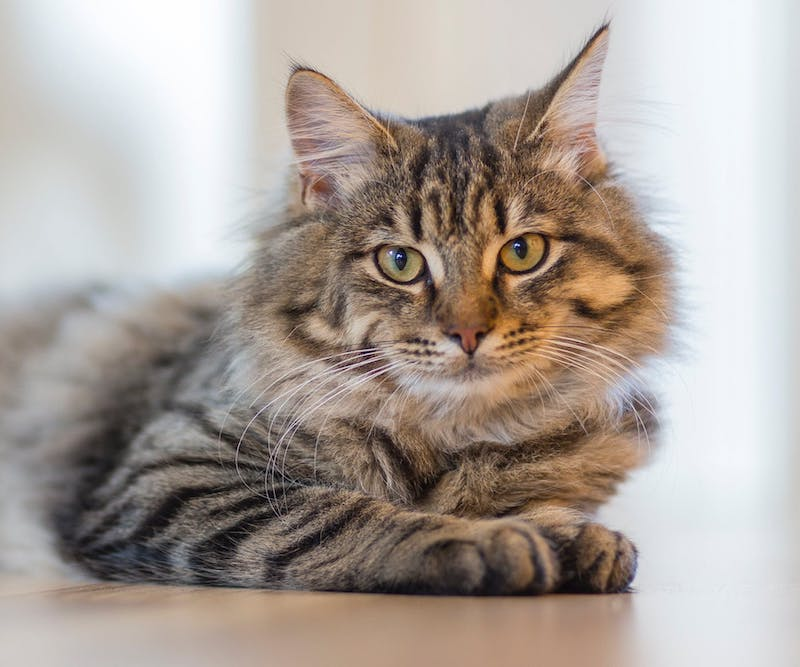

In [16]:
Image('test/test-cat.jpg')

[
  {
    "mediaType": "image",
    "name": "cat1.jpg",
    "path": "./source/image/cat1.jpg"
  },
  {
    "mediaType": "image",
    "name": "cat2.jpg",
    "path": "./source/image/cat2.jpg"
  },
  {
    "mediaType": "image",
    "name": "cat3.jpg",
    "path": "./source/image/cat3.jpg"
  },
  {
    "mediaType": "audio",
    "name": "mixkit-cartoon-kitty-begging-meow-92.wav",
    "path": "./source/audio/mixkit-cartoon-kitty-begging-meow-92.wav"
  },
  {
    "mediaType": "video",
    "name": "cat-clean.mp4",
    "path": "./source/video/cat-clean.mp4"
  }
]


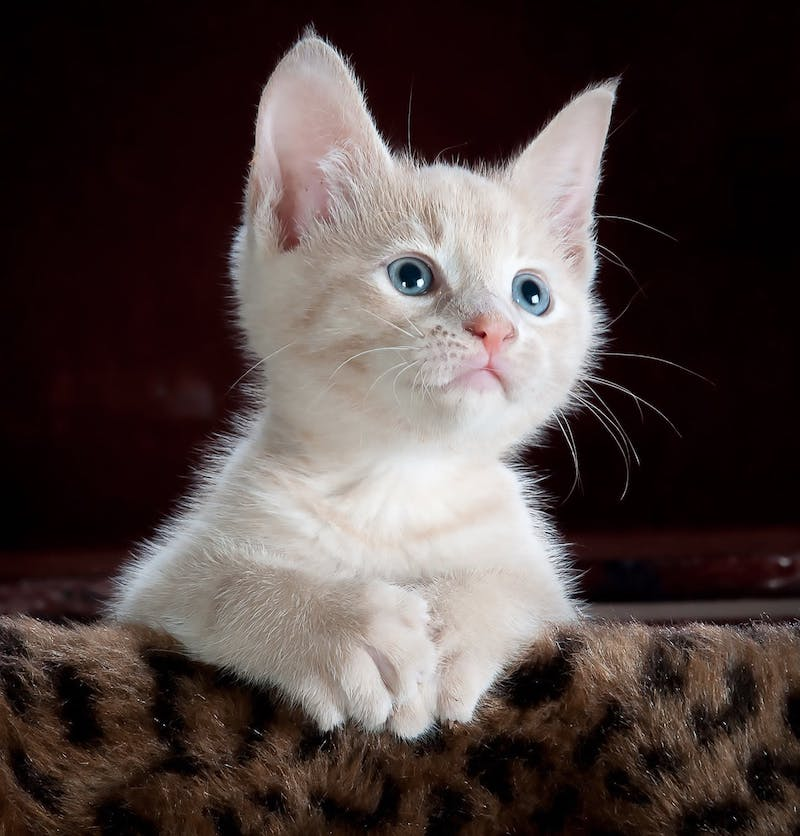

In [18]:
# Search for images that are similar to the provided image of test-meerkat, test-dog, test-cat
response = (
    client.query
    .get("Animals", "name path mediaType")
    .with_near_image(
        # {"image": "./test/test-meerkat.jpg"}, # Use file path as the input for the query
        # {"image": "./test/test-dog.jpg"}, # Use file path as the input for the query
        {"image": "./test/test-cat.jpg"}, # Use file path as the input for the query
    )
    .with_limit(5)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
display_media(result[0])

### Audio to Media search

In [20]:
Audio('./test/bird_audio.wav')

In [21]:
# Search for images that are similar to the provided image of test-meerkat, test-dog, test-cat
response = (
    client.query
    .get("Animals", "name path mediaType")
    .with_near_audio(
        {"audio": "./test/dog_audio.wav"}, # Use file path as the input for the query
        #{"audio": "./test/bird_audio.wav"}, # Use file path as the input for the query
    )
    .with_limit(5)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
display_media(result[0])

[
  {
    "mediaType": "video",
    "name": "dog-with-stick.mp4",
    "path": "./source/video/dog-with-stick.mp4"
  },
  {
    "mediaType": "video",
    "name": "dog-high-five.mp4",
    "path": "./source/video/dog-high-five.mp4"
  },
  {
    "mediaType": "audio",
    "name": "mixkit-dog-barking-twice-1.wav",
    "path": "./source/audio/mixkit-dog-barking-twice-1.wav"
  },
  {
    "mediaType": "image",
    "name": "dog2.jpg",
    "path": "./source/image/dog2.jpg"
  },
  {
    "mediaType": "image",
    "name": "dog3.jpg",
    "path": "./source/image/dog3.jpg"
  }
]


### Video to Media search

In [19]:
Video('test/test-meerkat.mp4')

In [20]:
# Search for images that are similar to the provided image of test-meerkat, test-dog, test-cat
response = (
    client.query
    .get("Animals", "name path mediaType")
    .with_near_video(
        # {"video": "./test/test-dog.mp4"}, # Use file path as the input for the query
        # {"video": "./test/test-cat.mp4"}, # Use file path as the input for the query
        {"video": "./test/test-meerkat.mp4"}, # Use file path as the input for the query
    )
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
display_media(result[0])

[
  {
    "mediaType": "video",
    "name": "meerkat-watch.mp4",
    "path": "./source/video/meerkat-watch.mp4"
  },
  {
    "mediaType": "video",
    "name": "meerkat-dig.mp4",
    "path": "./source/video/meerkat-dig.mp4"
  },
  {
    "mediaType": "image",
    "name": "meerkat3.jpg",
    "path": "./source/image/meerkat3.jpg"
  }
]
